In [ ]:
"""
Different rom other basic models
Dropout Regularization:

Added a dropout layer (Dropout(0.5)) after the dense layer to reduce overfitting by randomly dropping 50% of the neurons during training.
Early Stopping:

Implemented early stopping to stop training when the validation loss stops improving. The model restores the best weights from the point with the lowest validation loss.
Reduced Batch Size:

Reduced the batch size to 16 (from 32) to help the model learn more stable features, especially useful for small datasets.
    Increased Epochs with Early Stopping:

Increased the number of epochs to 50 to allow the model more time to learn, but early stopping will prevent overfitting by stopping the training when performance on the validation set stops improving."""

Label distribution:
anger: 30 images
neutral: 30 images
sadness: 31 images
surprise: 30 images
happiness: 31 images
fear: 32 images
disgust: 29 images
Running configuration: With Data Augmentation and Dropout
Test Accuracy: 83.72%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99

Summary of Results:
Configuration 1: Without Data Augmentation and Dropout,earlycallback,reduced batch size
Test Accuracy: 83.72%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99


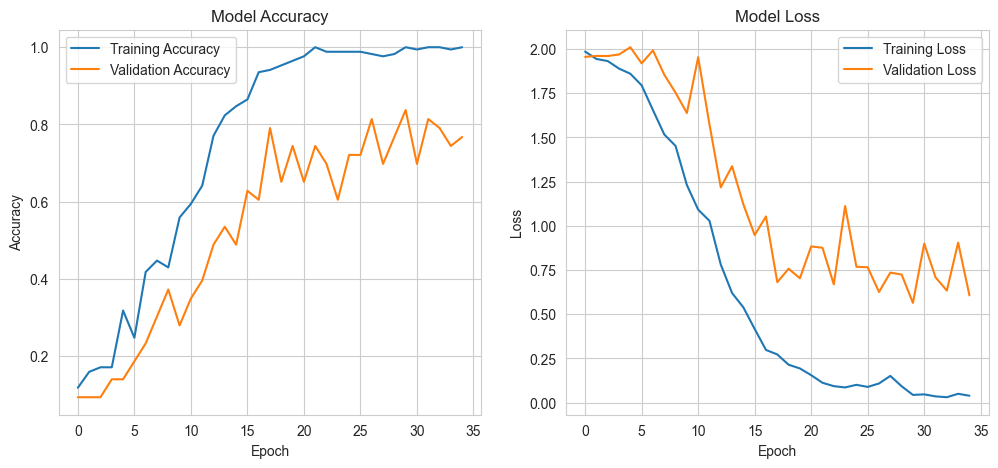

In [5]:
import os
import random
import numpy as np
from collections import Counter
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'/Users//Downloads/linda_trials/JAFFE Dataset'

# Function to load images and extract labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }

    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')  # Convert to grayscale
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Define the CNN architecture function with dropout for regularization
def create_model():
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        # Dropout(0.5),  # Add dropout to reduce overfitting
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize list to store results
results = []

# Data augmentation configuration with increased augmentation
datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=0.0,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=False
)

print(f"Running configuration: With Data Augmentation and Dropout")

# Create the model
model = create_model()

# Fit the data generator to the training data
datagen.fit(X_train)

# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using class weights and the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16, seed=42),
    validation_data=(X_test, y_test),
    epochs=50,  # Increased number of epochs to allow for early stopping
    class_weight=class_weights_dict,
    callbacks=[early_stopping],  # Add early stopping
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Store the configuration and results
config_results = {
    'config': 'Without Data Augmentation and Dropout,earlycallback,reduced batch size',
    'test_accuracy': test_acc,
    'precision': precision.result().numpy(),
    'recall': recall.result().numpy(),
    'f1_score': f1_score
}

# Print the results for this configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

results.append(config_results)

print("\nSummary of Results:")
for idx, result in enumerate(results):
    print(f"Configuration {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Label distribution:
anger: 30 images
neutral: 30 images
sadness: 31 images
surprise: 30 images
happiness: 31 images
fear: 32 images
disgust: 29 images
Running configuration 1/64
Configuration 1/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 60.47%
Precision: 0.97
Recall: 1.00
F1 Score: 0.99
Running configuration 2/64
Configuration 2/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': True}
Test Accuracy: 69.77%
Precision: 0.95
Recall: 1.00
F1 Score: 0.97
Running configuration 3/64
Configuration 3/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'horizontal_flip': False}
Test Accuracy: 6.98%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
Running configuration 4/64
Configuration 4/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rota

/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_1043/198895128.py:162: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())


Configuration 8/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 0, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'horizontal_flip': True}
Test Accuracy: 11.63%
Precision: 0.00
Recall: 0.00
F1 Score: nan
Running configuration 9/64
Configuration 9/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 15, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 23.26%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
Running configuration 10/64
Configuration 10/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 15, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': True}
Test Accuracy: 18.60%
Precision: 0.88
Recall: 1.00
F1 Score: 0.94
Running configuration 11/64
Configuration 11/64: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 15, 'width_shift_range': 0.0, 'height_shift_range': 0.1, 'horizontal_flip': False}
Test Accuracy: 23.26%
Precision: 0.88
Recall: 0.97
F1 Score: 0.92
Running con

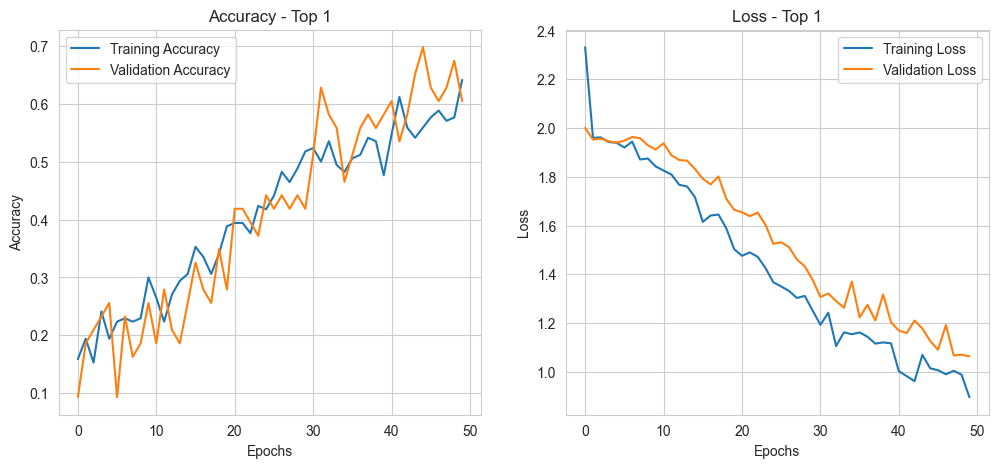

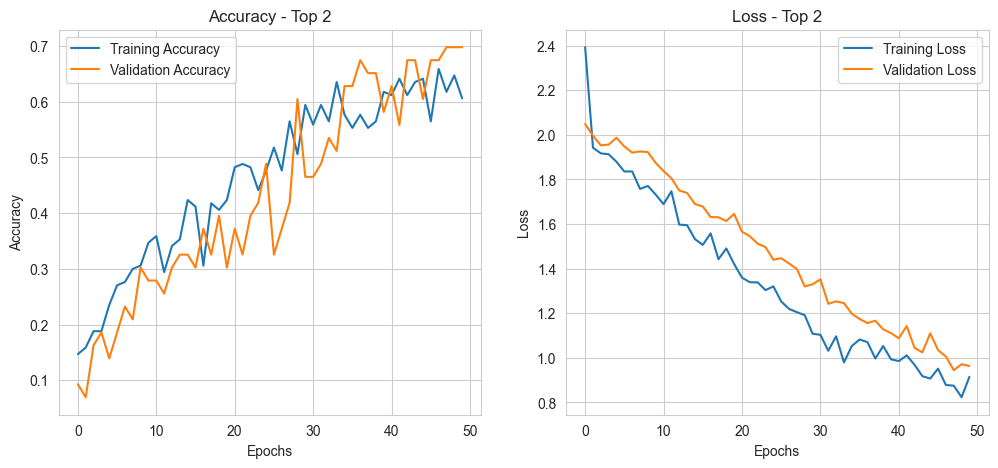

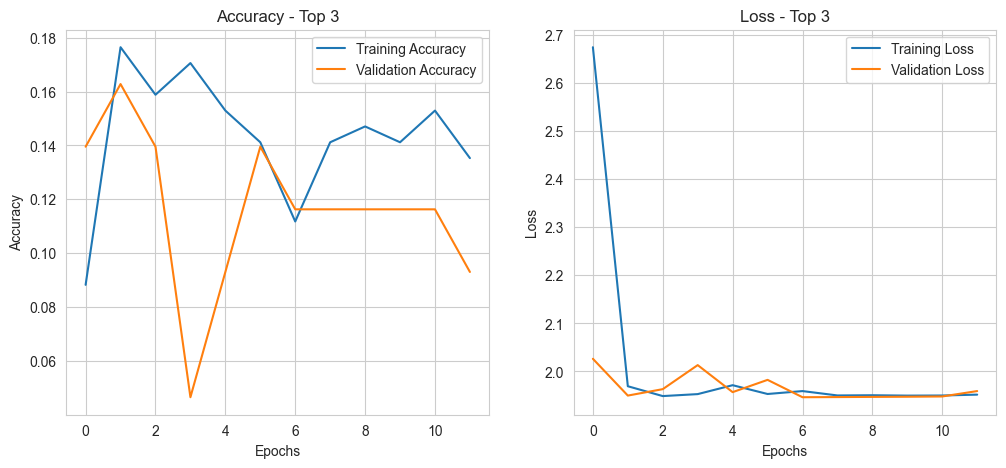

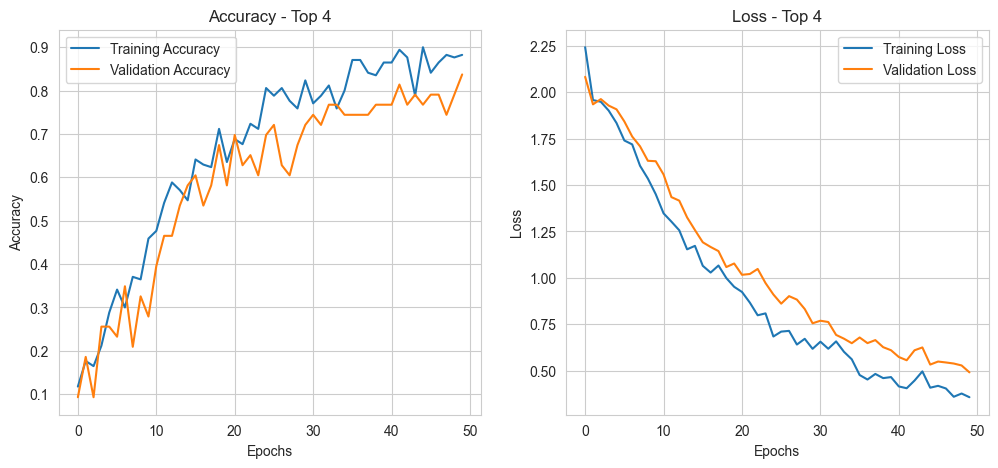

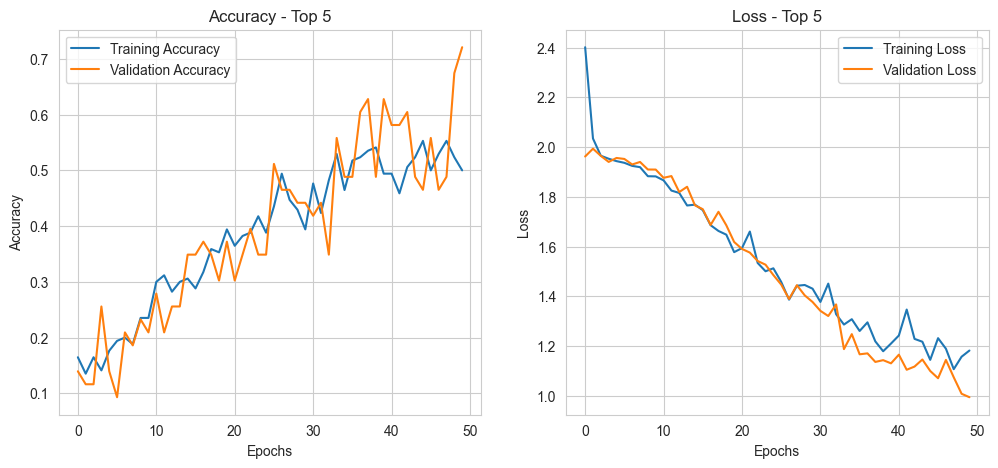

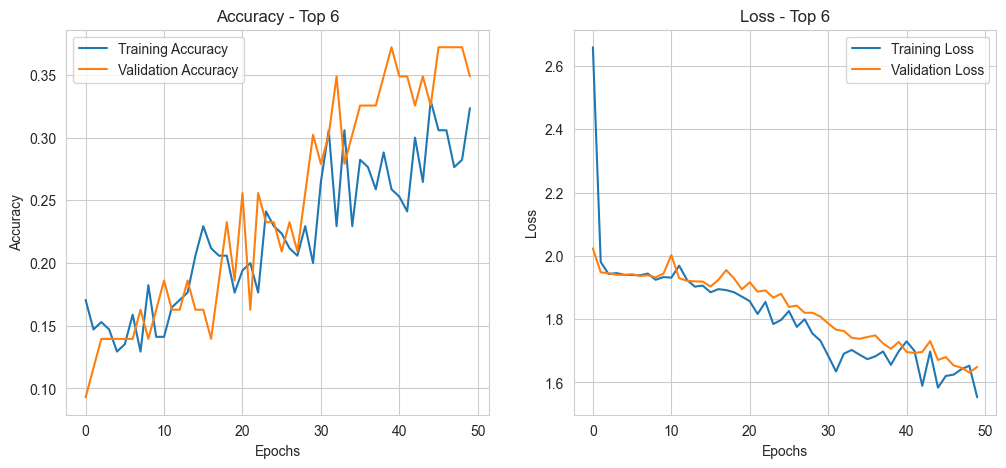

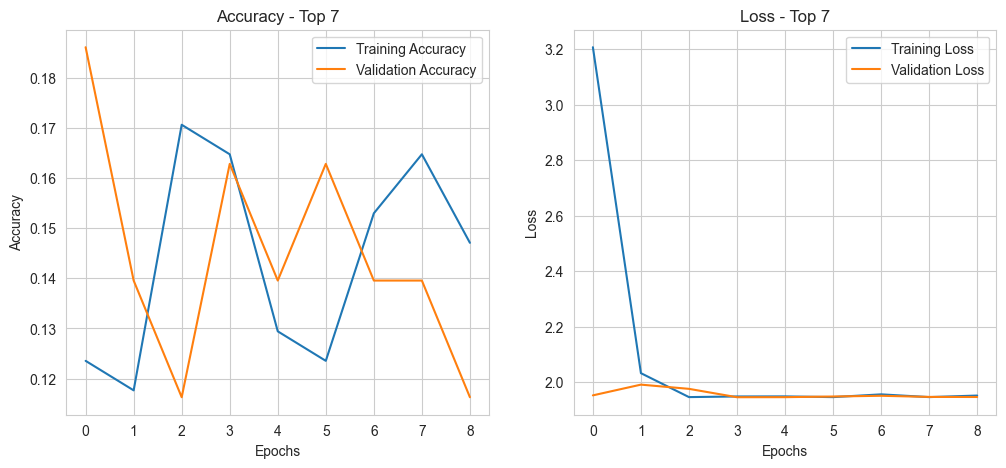

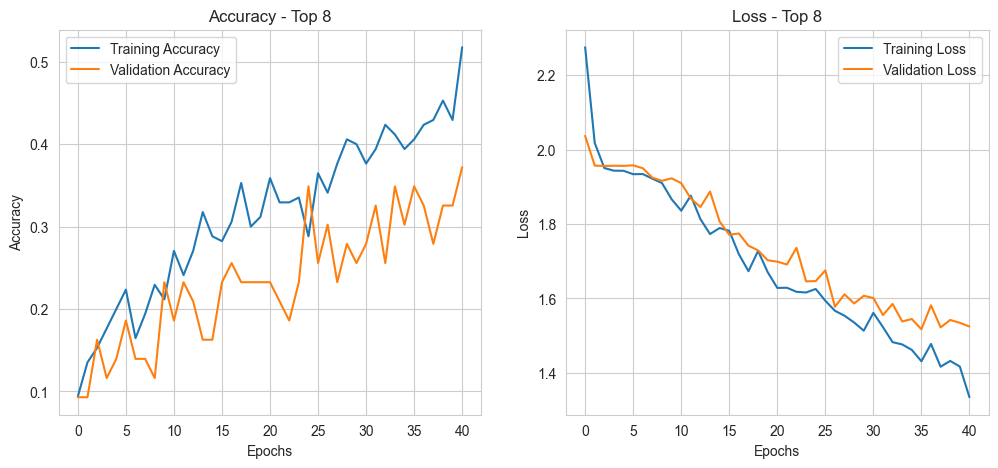

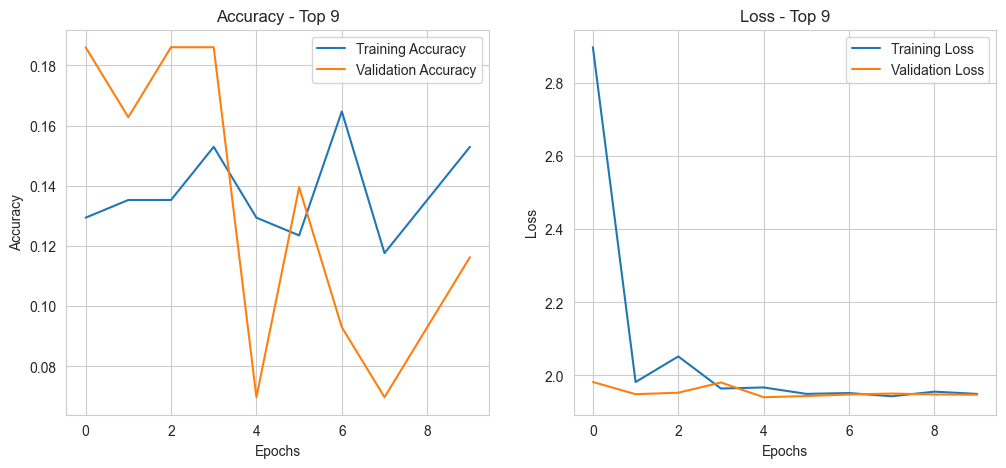

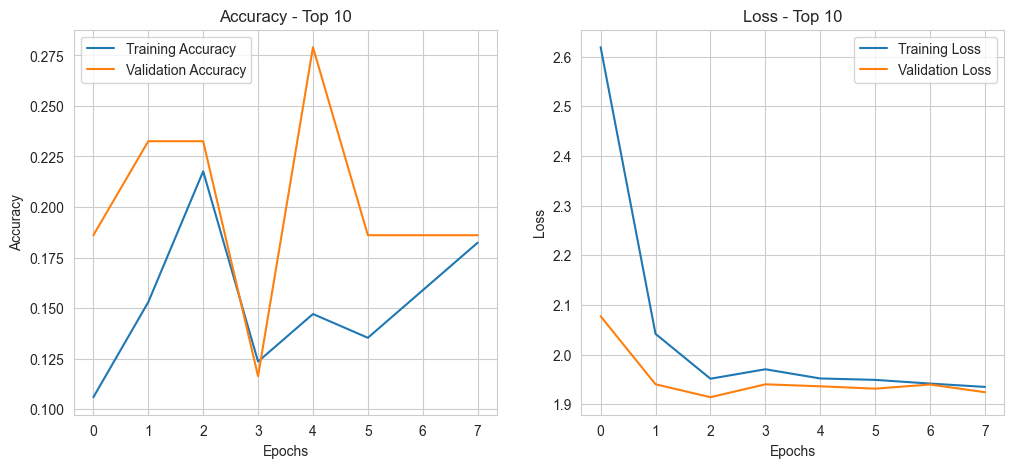

In [1]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the JAFEE dataset folder
dataset_folder = r'/Users//Downloads/linda_trials/JAFFE Dataset'

# Function to load images and extract labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }

    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')  # Convert to grayscale
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

# Function to define different augmentation combinations
def get_augmentation_combinations():
    shear_ranges = [0.0, 0.2]
    zoom_ranges = [0.0, 0.2]
    rotation_ranges = [0, 15]
    width_shift_ranges = [0.0, 0.1]
    height_shift_ranges = [0.0, 0.1]
    horizontal_flip_options = [False, True]
    combinations = list(product(shear_ranges, zoom_ranges, rotation_ranges,
                                width_shift_ranges, height_shift_ranges, horizontal_flip_options))

    return combinations

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Get augmentation combinations
augmentation_combinations = get_augmentation_combinations()

# Initialize list to store results
results = []

# Loop over all combinations
for idx, (shear, zoom, rotation, width_shift, height_shift, h_flip) in enumerate(augmentation_combinations):
    print(f"Running configuration {idx+1}/{len(augmentation_combinations)}")

    # Define the CNN architecture with dropout for regularization
    model = Sequential([
        InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
        Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
        MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
        Flatten(),  # Flatten the output for the dense layer
        Dense(100, activation='relu'),  # Fully connected layer
        Dropout(0.5),  # Add dropout to reduce overfitting
        Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Define data augmentation configuration
    datagen = ImageDataGenerator(
        shear_range=shear,
        zoom_range=zoom,
        rotation_range=rotation,
        width_shift_range=width_shift,
        height_shift_range=height_shift,
        horizontal_flip=h_flip
    )

    # Fit the data generator to the training data
    datagen.fit(X_train)

    # Add early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model using class weights and augmented data
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=16, seed=42),
        validation_data=(X_test, y_test),
        epochs=50,  # Increased number of epochs to allow for early stopping
        class_weight=class_weights_dict,
        callbacks=[early_stopping],  # Add early stopping
        verbose=0  # Suppress epoch prints
    )

    # Evaluate the model and store the results
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    precision = tf.keras.metrics.Precision()
    precision.update_state(true_classes, predicted_classes)
    recall = tf.keras.metrics.Recall()
    recall.update_state(true_classes, predicted_classes)
    f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

    # Store the configuration and results
    config_results = {
        'config': {
            'shear_range': shear,
            'zoom_range': zoom,
            'rotation_range': rotation,
            'width_shift_range': width_shift,
            'height_shift_range': height_shift,
            'horizontal_flip': h_flip
        },
        'test_accuracy': test_acc,
        'precision': precision.result().numpy(),
        'recall': recall.result().numpy(),
        'f1_score': f1_score,
        'history': history.history  # Save training history for later plotting
    }

    # Print the results for this configuration
    print(f"Configuration {idx+1}/{len(augmentation_combinations)}: {config_results['config']}")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Precision: {precision.result().numpy():.2f}")
    print(f"Recall: {recall.result().numpy():.2f}")
    print(f"F1 Score: {f1_score:.2f}")
    print("="*50)

    results.append(config_results)

# Sort results by F1 score to find the top 10 configurations
sorted_results = sorted(results, key=lambda x: x['f1_score'], reverse=True)[:10]

print("\nTop 10 Augmentation Configurations:")
for idx, result in enumerate(sorted_results):
    print(f"Rank {idx+1}: {result['config']}")
    print(f"Test Accuracy: {result['test_accuracy']*100:.2f}%")
    print(f"Precision: {result['precision']:.2f}")
    print(f"Recall: {result['recall']:.2f}")
    print(f"F1 Score: {result['f1_score']:.2f}")
    print("="*50)

# Plot the accuracy and loss for the top 10 configurations
for idx, result in enumerate(sorted_results):
    history = result['history']
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - Top {idx+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - Top {idx+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Running configuration 1/128
{'config': {'conv_layers': 1, 'filters': 16, 'dense_layers': 1, 'dense_units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.23255814611911774, 'precision': 1.0, 'recall': 0.8684211, 'f1_score': 0.9295774791666827, 'history': <keras.src.callbacks.history.History object at 0x3aceb2260>}
Running configuration 2/128
{'config': {'conv_layers': 1, 'filters': 16, 'dense_layers': 1, 'dense_units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.1627907007932663, 'precision': 0.9047619, 'recall': 1.0, 'f1_score': 0.9500000031292438, 'history': <keras.src.callbacks.history.History object at 0x3b370e5c0>}
Running configuration 3/128
{'config': {'conv_layers': 1, 'filters': 16, 'dense_layers': 1, 'dense_units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'a

/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_1043/1175966552.py:157: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())


{'config': {'conv_layers': 1, 'filters': 16, 'dense_layers': 1, 'dense_units': 32, 'dropout': 0.5, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.11627907305955887, 'precision': 0.0, 'recall': 0.0, 'f1_score': nan, 'history': <keras.src.callbacks.history.History object at 0x36e9b3910>}
Running configuration 12/128
{'config': {'conv_layers': 1, 'filters': 16, 'dense_layers': 1, 'dense_units': 32, 'dropout': 0.5, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}, 'test_accuracy': 0.13953489065170288, 'precision': 0.88372093, 'recall': 1.0, 'f1_score': 0.9382716369708861, 'history': <keras.src.callbacks.history.History object at 0x3c4247550>}
Running configuration 13/128
{'config': {'conv_layers': 1, 'filters': 16, 'dense_layers': 1, 'dense_units': 32, 'dropout': 0.5, 'epochs': 100, 'batch_size': 16, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}, 't

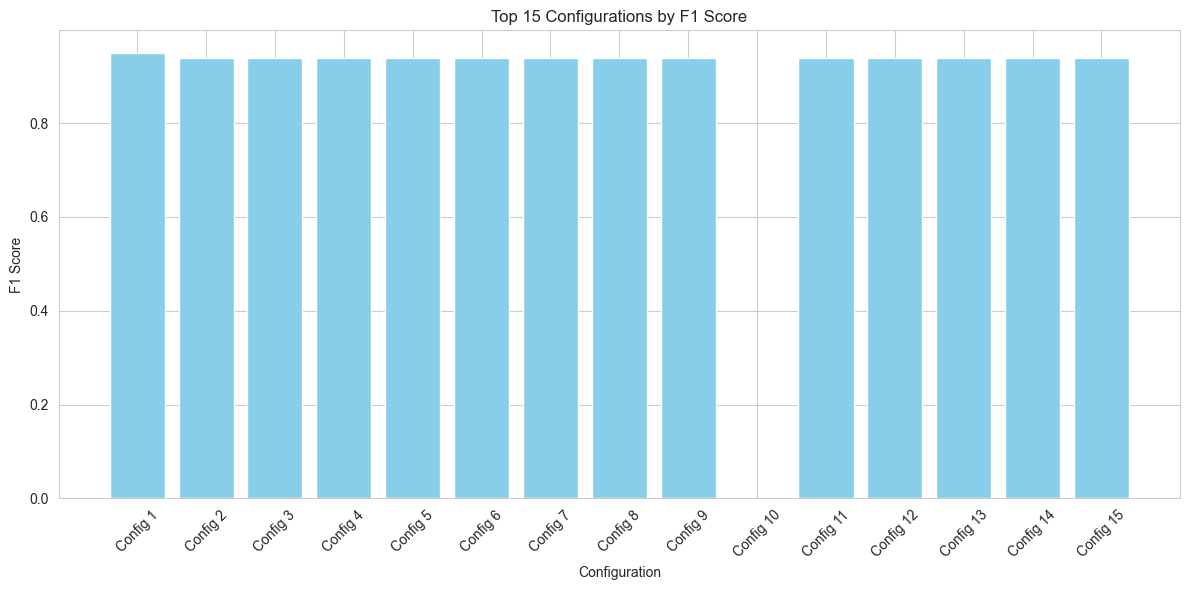

Top 1 Configuration:
Config Details: {'conv_layers': 1, 'filters': 16, 'dense_layers': 1, 'dense_units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 0.1628, Precision: 0.9048, Recall: 1.0000, F1 Score: 0.9500

Top 2 Configuration:
Config Details: {'conv_layers': 1, 'filters': 16, 'dense_layers': 1, 'dense_units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 0.0930, Precision: 0.8837, Recall: 1.0000, F1 Score: 0.9383

Top 3 Configuration:
Config Details: {'conv_layers': 1, 'filters': 16, 'dense_layers': 1, 'dense_units': 32, 'dropout': 0.2, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.002, 'activation': 'relu', 'optimizer': 'adam'}
Test Accuracy: 0.0930, Precision: 0.8837, Recall: 1.0000, F1 Score: 0.9383

Top 4 Configuration:
Config Details: {'conv_layers': 1, 'filters': 16, 'dense_layers': 1, 'dense_uni

In [4]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'/Users//Downloads/linda_trials/JAFFE Dataset'

# Function to load images and extract labels
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }

    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')  # Convert to grayscale
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

# Load images and labels
try:
    images, labels = load_images_and_labels(dataset_folder)
    images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input
except Exception as e:
    print(f"Error loading images: {e}")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Data augmentation generator
data_gen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.0,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

parameter_combinations = list(product(
    [1,2],              # conv_layers: Stick with 1 convolutional layer for simplicity.
    [16, 32],         # filters: Use either 16 or 32 filters.
    [1],              # dense_layers: Stick with 1 dense layer.
    [32, 64],         # dense_units: Test 32 or 64 units in the dense layer.
    [0.2, 0.5],       # dropout: Use a fixed dropout rate of 0.2.
    [50, 100],        # epochs: Reduce to 20 or 30 epochs, considering the small dataset size.
    [16, 32],         # batch_size: Use a smaller batch size of 16 or 32.
    [0.001,0.002],          # learning_rate: Keep the learning rate fixed at 0.001.
    ['relu'],         # activation: Use ReLU activation.
    ['adam']          # optimizer: Use the Adam optimizer.
))


# Loop over configurations
config_results = []

for idx, (conv_layers, filters, dense_layers, dense_units, dropout, epochs, batch_size, learning_rate, activation, optimizer) in enumerate(parameter_combinations):
    try:
        print(f"Running configuration {idx+1}/{len(parameter_combinations)}")
        model = Sequential()
        model.add(InputLayer(input_shape=(64, 64, 1)))
        for _ in range(conv_layers):
            model.add(Conv2D(filters, kernel_size=(3, 3), activation=activation))
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        for _ in range(dense_layers):
            model.add(Dense(dense_units, activation=activation))
            model.add(Dropout(dropout))
        model.add(Dense(len(np.unique(labels_encoded)), activation='softmax'))

        if optimizer == 'adam':
            optimizer_instance = Adam(learning_rate=learning_rate)
        else:
            optimizer_instance = SGD(learning_rate=learning_rate)
        model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train with data augmentation and early stopping
        train_gen = data_gen.flow(X_train, y_train, batch_size=batch_size)
        history = model.fit(train_gen, epochs=epochs, validation_data=(X_test, y_test),
                            class_weight=class_weights_dict, verbose=0, callbacks=[early_stopping])

        # Evaluate
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        predictions = model.predict(X_test, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y_test, axis=1)

        precision = tf.keras.metrics.Precision()
        precision.update_state(true_classes, predicted_classes)
        recall = tf.keras.metrics.Recall()
        recall.update_state(true_classes, predicted_classes)
        f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

        config_results.append({
            'config': {
                'conv_layers': conv_layers,
                'filters': filters,
                'dense_layers': dense_layers,
                'dense_units': dense_units,
                'dropout': dropout,
                'epochs': epochs,
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'activation': activation,
                'optimizer': optimizer
            },
            'test_accuracy': test_acc,
            'precision': precision.result().numpy(),
            'recall': recall.result().numpy(),
            'f1_score': f1_score,
            'history': history
        })

        # Print current configuration results
        print(config_results[-1])
    except Exception as e:
        print(f"Failed to run configuration {idx+1} due to: {e}")

# Sort the results based on F1-score in descending order
sorted_results = sorted(config_results, key=lambda x: x['f1_score'], reverse=True)

# Get the top 15 configurations
top_15_configs = sorted_results[:15]

# Extracting details for plotting
f1_scores = [result['f1_score'] for result in top_15_configs]
config_labels = [f"Config {i+1}" for i in range(15)]

# Plotting the top 15 configurations based on F1 score
plt.figure(figsize=(12, 6))
plt.bar(config_labels, f1_scores, color='skyblue')
plt.xlabel('Configuration')
plt.ylabel('F1 Score')
plt.title('Top 15 Configurations by F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

# Optionally, print out details of the top 15 configurations
for idx, result in enumerate(top_15_configs):
    config_details = result['config']
    print(f"Top {idx+1} Configuration:")
    print(f"Config Details: {config_details}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}, F1 Score: {result['f1_score']:.4f}\n")


Label distribution:
anger: 30 images
neutral: 30 images
sadness: 31 images
surprise: 30 images
happiness: 31 images
fear: 32 images
disgust: 29 images
Running with configuration: {'shear_range': 0.0, 'zoom_range': 0.0, 'rotation_range': 15, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'horizontal_flip': False}
Test Accuracy: 55.81%
Precision: 0.93
Recall: 0.97
F1 Score: 0.95


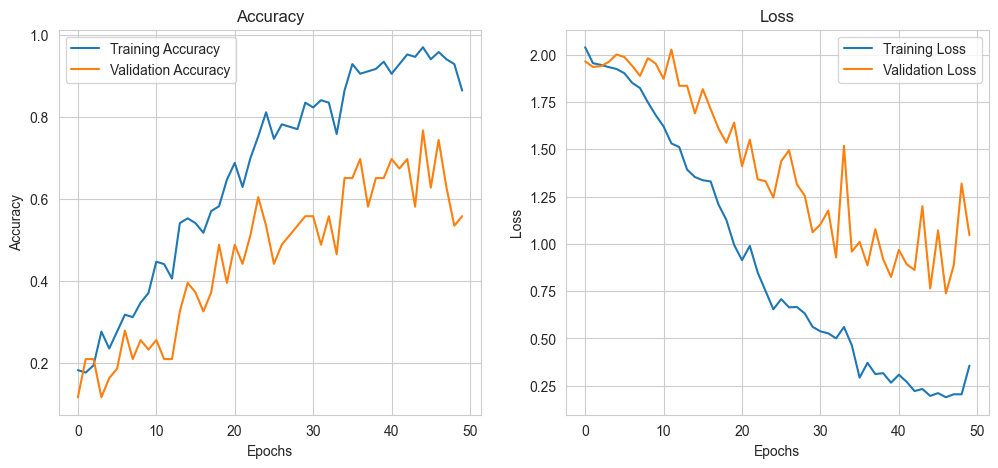

In [7]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
tf.get_logger().setLevel('ERROR')

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

set_seeds(42)

# Define the path to the dataset folder
dataset_folder = r'/Users//Downloads/linda_trials/JAFFE Dataset'

# Function to load images and extract labels (for JAFFE dataset)
def load_images_and_labels(folder):
    images = []
    labels = []
    label_map = {
        "AN": "anger",
        "DI": "disgust",
        "FE": "fear",
        "HA": "happiness",
        "SA": "sadness",
        "SU": "surprise",
        "NE": "neutral"
    }

    for filename in os.listdir(folder):
        if filename.endswith('.tiff'):
            image_file = os.path.join(folder, filename)
            img = Image.open(image_file).convert('L')  # Convert to grayscale
            img = img.resize((64, 64))  # Resize to 64x64 for consistency
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
            label_code = filename.split('.')[1][:2]
            labels.append(label_map[label_code])

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_labels(dataset_folder)
images = images.reshape(-1, 64, 64, 1)  # Reshape for CNN input

# Check for class imbalance
label_counts = Counter(labels)
print("Label distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} images")

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Specific augmentation configuration
augmentation_config = {
    'shear_range': 0.0,
    'zoom_range': 0.0,
    'rotation_range': 15,
    'width_shift_range': 0.0,
    'height_shift_range': 0.0,
    'horizontal_flip': False
}

print(f"Running with configuration: {augmentation_config}")

# Define the CNN architecture
model = Sequential([
    InputLayer(input_shape=(64, 64, 1)),  # Input layer for 64x64 grayscale images
    Conv2D(32, kernel_size=(3, 3), activation='relu'),  # First convolution layer
    MaxPooling2D(pool_size=(2, 2)),  # First pooling layer
    Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Second convolution layer
    MaxPooling2D(pool_size=(2, 2)),  # Second pooling layer
    Flatten(),  # Flatten the output for the dense layer
    Dense(100, activation='relu'),  # Fully connected layer
    Dense(len(np.unique(labels_encoded)), activation='softmax')  # Output layer with one neuron per class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define data augmentation configuration
datagen = ImageDataGenerator(
    shear_range=augmentation_config['shear_range'],
    zoom_range=augmentation_config['zoom_range'],
    rotation_range=augmentation_config['rotation_range'],
    width_shift_range=augmentation_config['width_shift_range'],
    height_shift_range=augmentation_config['height_shift_range'],
    horizontal_flip=augmentation_config['horizontal_flip']
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Train the model using class weights and augmented data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    validation_data=(X_test, y_test),
    epochs=50,
    class_weight=class_weights_dict,
    verbose=0  # Suppress epoch prints
)

# Evaluate the model and store the results
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

precision = tf.keras.metrics.Precision()
precision.update_state(true_classes, predicted_classes)
recall = tf.keras.metrics.Recall()
recall.update_state(true_classes, predicted_classes)
f1_score = 2 * (precision.result().numpy() * recall.result().numpy()) / (precision.result().numpy() + recall.result().numpy())

# Print the results for the configuration
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision.result().numpy():.2f}")
print(f"Recall: {recall.result().numpy():.2f}")
print(f"F1 Score: {f1_score:.2f}")
print("="*50)

# Plot the accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
